In [1]:
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torchvision.models as models
from  torch.utils.data import Dataset
from PIL import Image
import os
import glob
import torchvision
import torchvision.ops as ops
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2


# MODEL

In [4]:
class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        self.vgg19 = models.vgg19(pretrained=False)
        self.vgg19.load_state_dict(torch.load("./vgg19-dcbb9e9d.pth"))
        self.vgg19.features[30] = nn.AdaptiveAvgPool2d((7, 7))  # change
        self.vgg19.classifier= nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(25088, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.vgg19(x)
        return x


Model(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Co

# DATASET

In [5]:
IMAGE_SIZE=224
class Data(Dataset):
    def __init__(self,root_dir,image_dir="images",label_dir="labels",transform=None):
        self.root_dir=root_dir
        self.label_path=os.path.join(self.root_dir,label_dir)
        self.image_path=os.path.join(self.root_dir,image_dir)
        self.image_list=glob.glob(os.path.join(self.image_path,"*.png"))
        self.transform=transform


    def __getitem__(self,idx):
        img_name=self.image_list[idx]
        img=Image.open(img_name).convert('RGB')
        label_name= os.path.join(self.label_path,os.path.basename(img_name).split('.')[0]+'.txt')
        with open(label_name,"r") as f:
            line= f.readline().strip()
        label=[float(t) for t in line.split()[1:]]
        label=torch.tensor([label[0]-label[2]/2,label[1]-label[3]/2,label[0]+label[2]/2,label[1]+label[3]/2])
        if self.transform:
            img = self.transform(img)

        return img,label
    def __len__(self):
        return len(self.image_list)

In [8]:

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data=Data(root_dir="./dataset/train",transform=transform)
test_data=Data(root_dir="./dataset/test",transform=transform)

print(len(train_data))
print(len(test_data))


340
50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


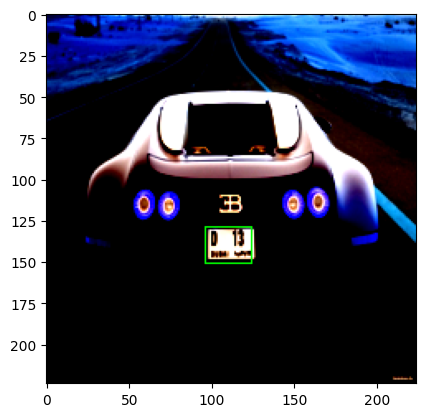

In [8]:
a,b,c,d=(train_data[0][1].numpy()*IMAGE_SIZE).astype(int)
img=cv2.cvtColor(train_data[0][0].numpy().transpose((1,2,0)), cv2.COLOR_RGB2BGR)
plt.imshow(cv2.rectangle(img,(a,b),(c,d),(0,255,0)))

In [9]:

def calculate_metrics(predictions, targets, threshold=0.5):

    true_positives = torch.zeros(1)
    false_positives = torch.zeros(1)
    false_negatives = torch.zeros(1)


    for prediction, target in zip(predictions, targets):

        iou = ops.box_iou(prediction.unsqueeze(0), target.unsqueeze(0))[0][0]

        if iou >= threshold:
            true_positives += 1
        else:
            false_positives += 1


    precision = true_positives


    return precision

# example
predictions = torch.tensor([[0, 0, 10, 10], [0, 0, 10, 10]])
targets = torch.tensor([[0, 0, 10, 10], [5, 5, 15, 15]])

count= calculate_metrics(predictions, targets)

print("count:", count)


Precision: tensor([1.])


# train

In [10]:
train_dataloader=DataLoader(train_data,batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [11]:
vgg=Model()
if torch.cuda.is_available():
    vgg = vgg.cuda()


loss_fn = nn.MSELoss()
if torch.cuda.is_available():
    loss_fn = loss_fn.cuda()
learning_rate=0.001
optimizer=torch.optim.Adam([
{
    'params':vgg.vgg19.classifier.parameters(),
}]
 ,lr=learning_rate)


total_train_step=0
total_test_step=0
epoch=200

In [12]:
writer=SummaryWriter("./vgglogs/logs_train_gpu")

In [14]:
test_data_size=len(test_data)


for i in range(epoch):
    print("---------{} start---------".format(i+1))


    # train
    vgg.train()
    for data in train_dataloader:
        imgs,targets=data
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            targets = targets.cuda()
        outputs=vgg(imgs)
        loss=loss_fn(outputs,targets)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        total_train_step = total_train_step + 1
        if total_train_step % 50 == 0:
            print("num：{},Loss:{}".format(total_train_step,loss.item()))
            writer.add_scalar("train_loss",loss.item(),total_train_step)


    # eval
    vgg.eval()
    total_test_loss=0
    total_accuracy=0
    total_precision=0
    total_recall=0
    total_average_precision=0

    with torch.no_grad():
        for data in test_dataloader:
            imgs,targets=data
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                targets = targets.cuda()
            outputs=vgg(imgs)
            loss = loss_fn(outputs, targets)
            total_test_loss = total_test_loss + loss.item()
            precision=calculate_metrics(outputs,targets)
            total_precision+=precision.item()#, recall.item(), average_precision.item()
    print("total Loss in test: {}".format(total_test_loss))
    print(" precision{}".format( precision))#, recall/test_data_size, average_precision/test_data_size))
    writer.add_scalar("test_loss", total_test_loss, total_test_step)
    writer.add_scalar("test_precision", total_precision/test_data_size, total_test_step)
    # writer.add_scalar("test_recall", total_recall/test_data_size, total_test_step)
    # writer.add_scalar("test_map50", total_average_precision/test_data_size, total_test_step)
    total_test_step = total_test_step + 1

---------1 start---------
total Loss in test: 0.07668587565422058
 precisiontensor([3.])
---------2 start---------
total Loss in test: 0.08164440095424652
 precisiontensor([2.])
---------3 start---------
total Loss in test: 0.037976205348968506
 precisiontensor([2.])
---------4 start---------
total Loss in test: 0.03127266839146614
 precisiontensor([2.])
---------5 start---------
total Loss in test: 0.03432565927505493
 precisiontensor([3.])
---------6 start---------
total Loss in test: 0.03313930705189705
 precisiontensor([2.])
---------7 start---------
total Loss in test: 0.026377342641353607
 precisiontensor([5.])
---------8 start---------
total Loss in test: 0.0268436037003994
 precisiontensor([8.])
---------9 start---------
num：50,Loss:0.008419668301939964
total Loss in test: 0.025555117055773735
 precisiontensor([6.])
---------10 start---------
total Loss in test: 0.023729251697659492
 precisiontensor([8.])
---------11 start---------
total Loss in test: 0.023945793509483337
 prec

In [3]:
torch.save(vgg, "vgg_{}.pth".format(200))

NameError: name 'vgg' is not defined

# test

In [9]:
val_data=Data(root_dir="./dataset/val",transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


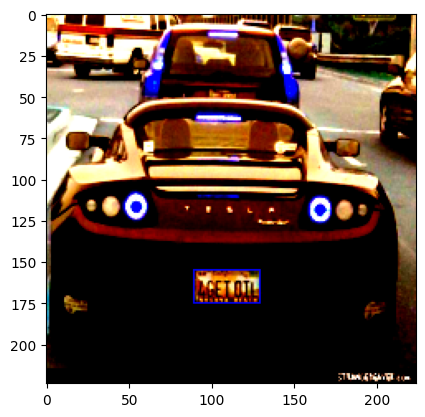

In [25]:
a,b,c,d=(val_data[0][1].numpy()*IMAGE_SIZE).astype(int)
img2=cv2.cvtColor(val_data[0][0].numpy().transpose((1,2,0)), cv2.COLOR_RGB2BGR)
plt.imshow(cv2.rectangle(img2,(a,b),(c,d),(0,0,255)))

In [27]:
model = torch.load("vgg_2001.pth", map_location=torch.device('cpu'))
model.eval()
with torch.no_grad():
    output = model(val_data[0][0][None])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


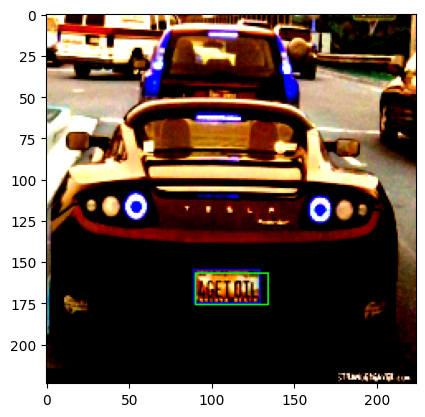

In [28]:
a,b,c,d=(output.detach().cpu().numpy()[0]*IMAGE_SIZE).astype(int)
plt.imshow(cv2.rectangle(img2,(a,b),(c,d),(0,255,0)))